IntProgress(value=0, description='Progress: ', layout=Layout(height='80%', width='90%'), max=10000000)

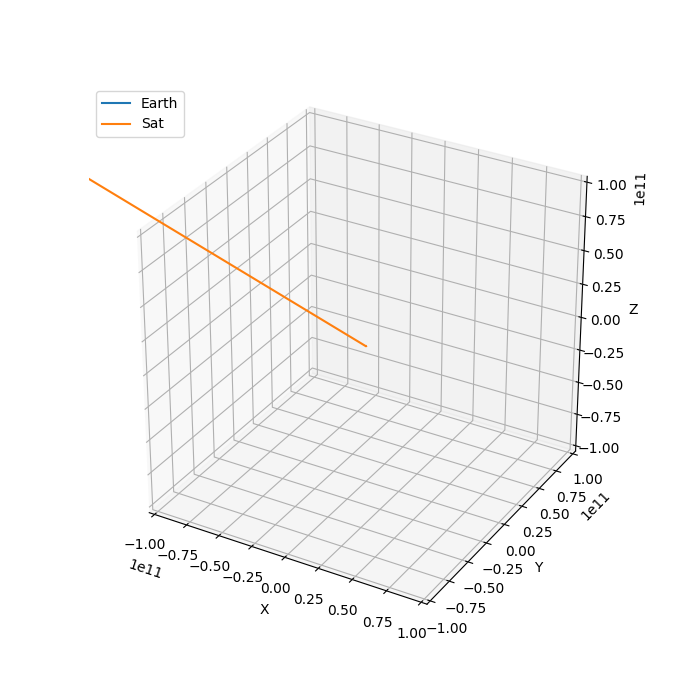

In [1]:
# Code written by Liam McCord
%matplotlib widget
# Importing section 
import math
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import plotly
import plotly.graph_objs as go
import random
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import IntProgress, Layout
from IPython.display import display


#This defines some initial lists for storing info later on.
n_body_storage = []
body_storage = []
Graphing_Data = []
Temp_Graph_Data = []

# This reads a CSV file and loads the information about the starting positions, masses, velocities, and radii of the bodies in question. Provided the formatting is correct this should be able to read custom info.
n_body_dataframe = pd.read_csv('PlanetStartStats.csv')

# SecondsPerStep dictates how often forces, acceleration, velocity, and positions should be recalculated. The higher the number inputted, the less accurate the simulation, but processing time is decreased in turn.
SecondsPerStep = 1 / int(input("How many seconds should pass before recalculating forces? "))

    
# MaxSimulationTime just defines the point where the simulation stops.
MaxSimulationTime = int(input("How long would you like the simulation to be (in seconds)? "))

#Visual progress bar
prog_bar = IntProgress(min=0, max=MaxSimulationTime, description = "Progress: ", layout = Layout(width="90%", height="80%") )
display(prog_bar)

#Specifies an empty array
n_body_array = np.empty(len(n_body_dataframe))


# This specifies the 6 slots needed for each directional position and velocity stored
n_body_array = [[[], [], [], [], [], []] for _ in range(len(n_body_dataframe))]


#This part converts the dataframe csv file into an array.
transfercounter = 0
while transfercounter < len(n_body_dataframe):
    
    empty_position_index = 0
    
    while empty_position_index < 6:
        
        templist = [0] * (int(math.ceil(MaxSimulationTime / (1 / SecondsPerStep))) + 1)
        templist[0] = n_body_dataframe.iloc[transfercounter, empty_position_index + 1]
        n_body_array[transfercounter][empty_position_index] = templist
        
        empty_position_index = empty_position_index + 1
    transfercounter = transfercounter + 1
n_body_array = np.array(n_body_array)


active_body = 0
# Physics Constants
GravConstant =  6.67e-11

# dt is change in time (for recalculation step frequency, the simulation time will remain constant)
dt = 1 / SecondsPerStep
t = 0
time_sequence = 0


while t < MaxSimulationTime:
    #This goes through active bodies
    t = t + dt
    prog_bar.value = t
    active_body = 0
    while active_body < len(n_body_dataframe):
        # This specifies the conditions of the active body for the step
        XPos1 = n_body_array[active_body][0][time_sequence]
        YPos1 = n_body_array[active_body][1][time_sequence]
        ZPos1 = n_body_array[active_body][2][time_sequence]
        XVel1 = n_body_array[active_body][3][time_sequence]
        YVel1 = n_body_array[active_body][4][time_sequence]
        ZVel1 = n_body_array[active_body][5][time_sequence]
        
        bodies_done = 0
        
        n_body_array_active_dropped = np.delete(n_body_array, active_body)

        n_body_dataframe_active_dropped = n_body_dataframe.drop(active_body)

        XGravAccel1 = 0
        YGravAccel1 = 0
        ZGravAccel1 = 0
        #This goes through non-active bodies        
        while bodies_done < len(n_body_array) - 1:
            if bodies_done != active_body:
                # This specifies the conditions of the non-active body for the step
                XPos2 = n_body_array[bodies_done][0][time_sequence]
                YPos2 = n_body_array[bodies_done][1][time_sequence]
                ZPos2 = n_body_array[bodies_done][2][time_sequence]
                
                Object2Mass = n_body_dataframe_active_dropped.iloc[bodies_done, 8]

                XSeparation = (XPos1 - XPos2)
                YSeparation = (YPos1 - YPos2)
                ZSeparation = (ZPos1 - ZPos2)


                # The shortest line between both objects, used to calculate gravitational pull as only the magnitude matters
                Separation = ((XSeparation ** 2) + (YSeparation ** 2) + (ZSeparation ** 2)) ** 0.5

                # The acceleration from the object based on the raw distance, derived from F = ma and the universal gravitational equation.
                AccelMag = (GravConstant * Object2Mass) / (Separation ** 2)
                #print(AccelMag)

                # These parts use trig to calculate the angle between the line that links the COMs of both objects and the proper coordinate vectors. This is just a line that touches the middle of both objects.
                AngleX = math.acos(XSeparation / Separation)
                AngleY = math.acos(YSeparation / Separation)
                AngleZ = math.acos(ZSeparation / Separation)

                # This calculates acceleration in each direction by using the raw acceleration (AccelMag) and the angle between it and the individual basis directions (X Y and Z). This gives the acceleration in each direction of the active body.
                XGravAccel1 = XGravAccel1 + (-1 * AccelMag * math.cos(AngleX))
                YGravAccel1 = YGravAccel1 + (-1 * AccelMag * math.cos(AngleY))
                ZGravAccel1 = ZGravAccel1 + (-1 * AccelMag * math.cos(AngleZ))
                
            bodies_done = bodies_done + 1     
            
        # Update velocity of active body
        n_body_array[active_body, 3, time_sequence + 1] = n_body_array[active_body, 3, time_sequence] + (XGravAccel1 * dt)
        n_body_array[active_body, 4, time_sequence + 1] = n_body_array[active_body, 4, time_sequence] + (YGravAccel1 * dt)     
        n_body_array[active_body, 5, time_sequence + 1] = n_body_array[active_body, 5, time_sequence] + (ZGravAccel1 * dt) 

        
        # Update position of active body
        n_body_array[active_body, 0, time_sequence + 1] = n_body_array[active_body, 0, time_sequence] + (n_body_array[active_body, 3, time_sequence] * dt)
        n_body_array[active_body, 1, time_sequence + 1] = n_body_array[active_body, 1, time_sequence] + (n_body_array[active_body, 4, time_sequence] * dt)
        n_body_array[active_body, 2, time_sequence + 1] = n_body_array[active_body, 2, time_sequence] + (n_body_array[active_body, 5, time_sequence] * dt)
        active_body = active_body + 1
    time_sequence = time_sequence + 1


# Graphing section
fig = plt.figure(figsize = (7,7))

ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])

graphcounter = 0

# This just names the orbital paths from the CSV
for n in range(n_body_array.shape[0]):
    currentname = n_body_dataframe.iloc[n, 0]
    ax.plot3D(n_body_array[n, 0], n_body_array[n, 1], n_body_array[n, 2], label = currentname)

leg = plt.legend(loc='upper left')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

ax.set_xlabel('X')

ax.set_ylabel('Y')

ax.set_zlabel('Z')
#print(n_body_array)

x = 696340000 * np.outer(np.cos(u), np.sin(v))
y = 696340000 * np.outer(np.sin(u), np.sin(v))
z = 696340000 * np.outer(np.ones(np.size(u)), np.cos(v))

#ax.plot_surface(x, y, z, rstride=4, cstride=4, color='b')

# The area that the graph will show upon start
GraphAreaStart = 100000000000

ax.set_xlim3d(-1 * GraphAreaStart, GraphAreaStart)
ax.set_ylim3d(-1 * GraphAreaStart, GraphAreaStart)
ax.set_zlim3d(-1 * GraphAreaStart, GraphAreaStart)

plt.show()